# **Introduction to Image Processing**

** Dear students this is your first assignment in Image processing course, in the context of this assignment you have to:**
* **complete `2-enhancement.ipynb` up to section 2.7**
* **complete this notebook `2-enhancement-supplementary.ipynb`**
* **add your changes, commit and push your completed assignment to your github repo**

`2-enhancement-supplememtary.ipynb` provides more information on section 2.7

## 2.7 Your own implementation 

### Q.1 Import the required libraries and functions

In [2]:
% matplotlib inline
% pprint off

### import the libraries you think its necessary for your task 
import matplotlib.pyplot as plt
from matplotlib import cm

# Numpy library
import numpy as np

from skimage import io

from skimage import exposure
import skimage


Pretty printing has been turned ON


### Q.2 Contrast streching 

** Define your function which stretch the image contrast, `cont_str`, using minimum and maximum values from the image **

**This function should accept the input image, calculates the minimum and maximum and rescales the intensities.**

** Return the image as uint8 **

In [3]:
def cont_str(x):
    max_i = np.max(x)
    min_i = np.min(x)
    print (max_i)
    print(min_i)
    return ((x-min_i)*(256/(max_i - min_i))).astype(np.uint8)

**Use your function to transform the  gray version of `satellite.jpg` image (ubyte format), show the original image and the transformed image and their histogram**

/home/roger/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


226
145


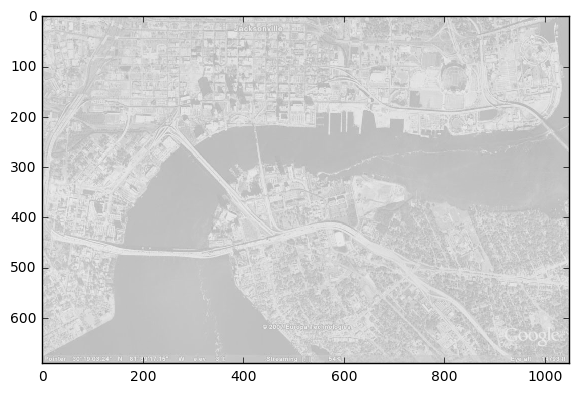

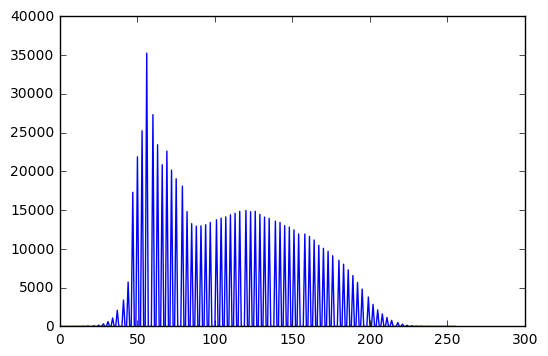

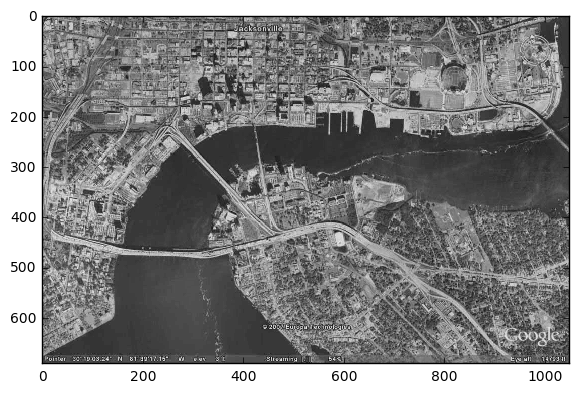

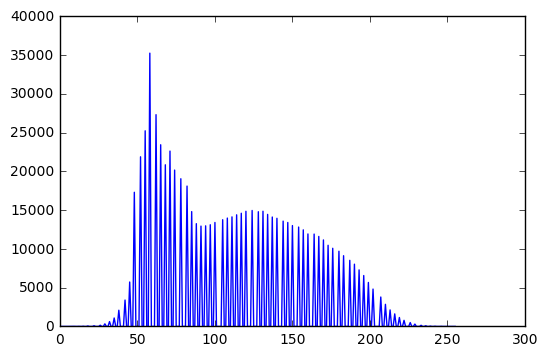

In [7]:
sat_img = skimage.img_as_ubyte(io.imread('./images/satellite.jpg', as_grey=True))

plt.figure()
io.imshow(sat_img,cmap=cm.Greys_r)

plt.figure()
bins, bins_c = np.histogram(sat_img, 256)
plt.plot(bins)


plt.figure()
x = cont_str(sat_img)
io.imshow(x)
plt.figure()
bins, bins_c = np.histogram(x, 256)
plt.plot(bins)


### Q.3 Histogram equalization
Histogram equalization can be used to enhance the contrast in images.

The idea behind the histogram equalization process is that each gray level should have an equal contribution in the image. The function allowing such transformation is in fact the cumulative density function.

**Define your own histgram equalization function, `hist_eq`**

**This function should accpet the image, max_int and min_int and return the transformed image and its cdf**

In [31]:

def hist_eq(im, min_i, max_i):
    
    # get image histogram
    histogram, bins = np.histogram(im.flatten(), bins = max_i - min_i, normed=True)
    cdf = histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_eq = np.interp(im.flatten(), bins[:-1], cdf)

    return image_eq.reshape(im.shape), cdf

** Use your function to transform the gray version of `satellite.jpg` image again in ubyte format**

** max_int = 255, min_int = 0 **

/home/roger/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


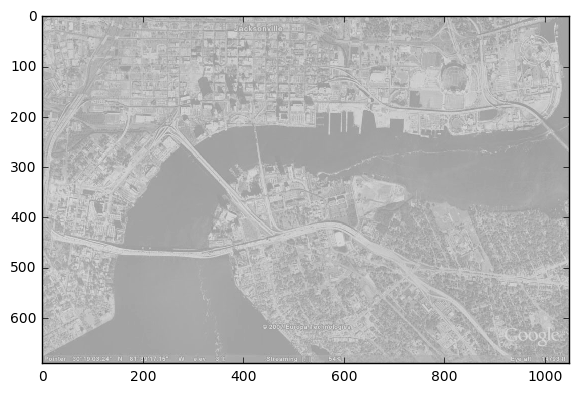

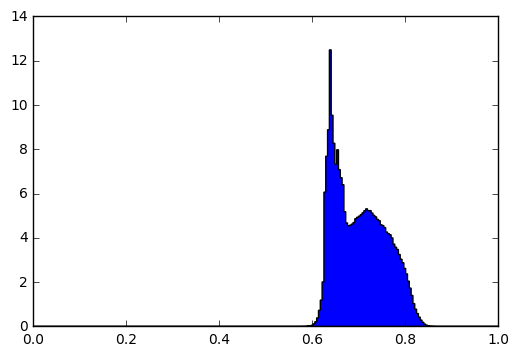

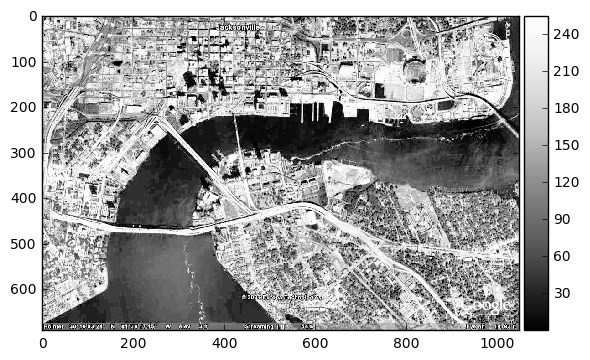

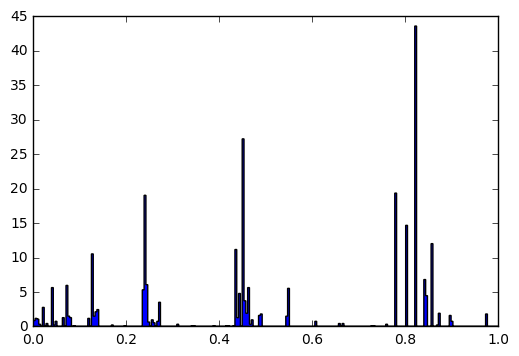

In [32]:

#Histogram equalization...
sat_img =io.imread('./images/satellite.jpg', as_grey=True)
# Show the magnitude image and its histogram
plt.figure()
io.imshow(sat_img)
plt.figure()
n, bins, patches = plt.hist(sat_img.flatten(), 256, range=(0., 1.), normed=1, histtype='stepfilled')

sat_img_float_eq, aux = hist_eq(sat_img, 0, 256)

# Show the magnitude image and its histogram
plt.figure()
io.imshow(sat_img_float_eq, cmap=cm.Greys_r)

plt.figure()
n, bins, patches = plt.hist(sat_img_float_eq.flatten(), 256, range=(0., 1.), normed=1, histtype='stepfilled')



**Show the transformed image and its histogram**

### Q.4 Histogram matching

** In this section we will perform histogram matching, the `hist_match` function is mostly defined here**
** `hist_match` uses the function that should define the Q.3 `hist_eq`, check the comments in the code as well **
 
** Explain the process of histogram matching in your own words**

In [34]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')



In [27]:
def hist_match(img, pdf_to_fit, min_int, max_int):

    ## function implemented in the previous Question 
    img_eq, cdf_eq = hist_eq(img, min_int, max_int)
    
    ### Compute the cdf
    cdf = np.cumsum(pdf_to_fit)
    
    ### Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    ### Round the cdf
    G = np.floor(cdf_real).astype('int')
    
    ## inverse
    G_1 = find_inverse_mapping(G)
    
    img_match = np.zeros((img_eq.shape[0], img_eq.shape[1]))
    for i in range (np.shape(img_eq)[0]):
        for j in range (np.shape(img_eq)[1]):
            img_match[i][j] = G_1[int(img_eq[i][j])]
    
    return img_match  

**Creating a manual pdf following a gaussian distribution**

/home/roger/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


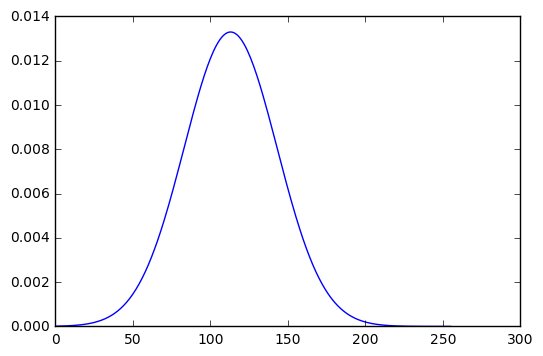

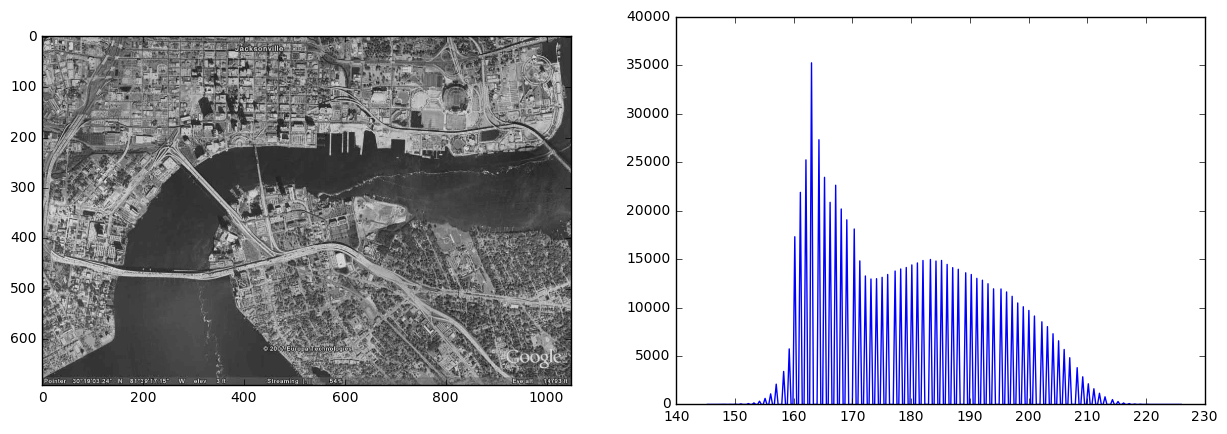

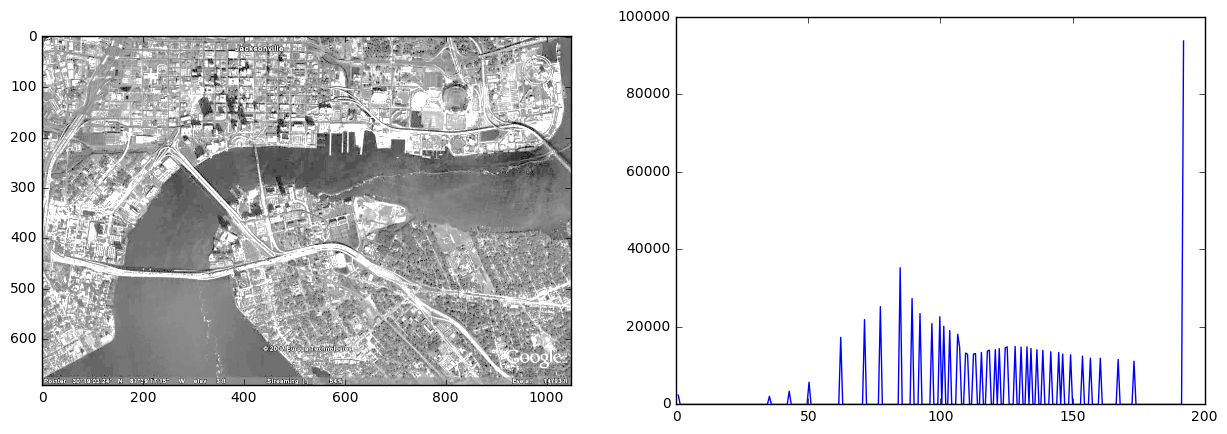

In [44]:
from scipy.stats import norm
img = io.imread('./images/satellite.jpg', as_grey=True)
sat_img=skimage.img_as_ubyte(img)
max_img=np.amax(sat_img)
x = np.arange(256)
pdf_to_fit = norm.pdf(x, max_img/2, 30)

plt.figure()
plt.plot(pdf_to_fit)



sat_matched=hist_match(sat_img, pdf_to_fit, sat_img.min(), sat_img.max())

fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax0, ax1= axes.ravel()
ax0.imshow(sat_img, cmap=cm.gray)
bins, bins_c=np.histogram(sat_img, 256)
ax1.plot(bins_c[1:], bins)




fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax0, ax1= axes.ravel()
ax0.imshow(sat_matched, cmap=cm.gray)

bins, bins_c=np.histogram(sat_matched, 256)
ax1.plot(bins_c[1:], bins)


**Use the defined function to match the histogram of gray version of satellite image to `pdf_to_fit`**



# asdj asd LaTeX: α2\alpha^2



### Q.5 

** Explain the difference between log transform enhancement and gamma transform **


log transformation is used to expand the range of dark pixels in an image and to shrink the range of the bright pixels.

Gamma transformation uses the exponential transfer function, but we can obtain diferent transformation curves using different gamma values. 



** Explain how sigmoid function enhances the image **

Sigmoid function exapands both darker and brighter sides. This is used for low contrast images because makes high levels even higher and low even lower.